In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import datetime
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

# Read in Data

In [3]:
df = pd.read_json('data/data.json', convert_dates=['approx_payout_date','event_created',\
                                               'event_end','event_published',\
                                               'event_start','sale_duration',\
                                               'sale_duration2','user_created'])

In [4]:
# Convert the type of event_published to datetime type.
df['event_published'] = df['event_published'].apply(lambda x: (pd.to_datetime(datetime.datetime.fromtimestamp(x).\
                                                    strftime('%Y-%m-%d %H:%M:%S'))) if pd.notnull(x) else x)

In [5]:
df.head(3)

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,2010-02-13 12:00:00,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,2010-01-06 01:01:46,2010-02-08 12:00:00,2010-01-09 23:50:38,2010-02-08 02:00:00,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,2009-11-30 20:45:50,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,2011-02-03 08:00:00,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,2010-12-31 21:57:50,2011-01-29 08:00:00,2010-12-31 14:08:15,2011-01-28 23:00:00,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{u'name': u'RUF', u'created': u'2010-10-01 01...",28.0,28,0,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,2010-08-04 17:26:16,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,2011-01-28 00:00:00,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,2010-11-30 04:22:36,2011-01-23 00:00:00,2010-11-29 20:38:28,2011-01-22 16:30:00,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{u'name': u'Danielle Severn', u'created': u'2...",54.0,54,0,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,2010-04-29 16:43:08,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA


In [6]:
# We have many different account types, we need to decide which should be put into fraud and not-fraud class, and not
# consider other account types for this case study.
df.acct_type.unique()

array([u'fraudster_event', u'premium', u'spammer_warn', u'fraudster',
       u'spammer_limited', u'spammer_noinvite', u'locked', u'tos_lock',
       u'tos_warn', u'fraudster_att', u'spammer_web', u'spammer'], dtype=object)

In [7]:
# We decide to only keep the following accout types, and ignore spam and other types right now.
df_new = df.loc[df.acct_type.isin(['premium','fraudster_event','fraudster','fraudster_att']), :].copy()

In [8]:
# We define'fraudster_event','fraudster','fraudster_att' as fraud class, and premium as not-fraud class.
df_new['fraud'] = 1
df_new.loc[df_new.acct_type == 'premium', 'fraud'] = 0

In [9]:
df_new.head(3)

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud
0,fraudster_event,2010-02-13 12:00:00,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,2010-01-06 01:01:46,2010-02-08 12:00:00,2010-01-09 23:50:38,2010-02-08 02:00:00,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,2009-11-30 20:45:50,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,1
1,premium,2011-02-03 08:00:00,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,2010-12-31 21:57:50,2011-01-29 08:00:00,2010-12-31 14:08:15,2011-01-28 23:00:00,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{u'name': u'RUF', u'created': u'2010-10-01 01...",28.0,28,0,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,2010-08-04 17:26:16,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,0
2,premium,2011-01-28 00:00:00,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,2010-11-30 04:22:36,2011-01-23 00:00:00,2010-11-29 20:38:28,2011-01-22 16:30:00,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{u'name': u'Danielle Severn', u'created': u'2...",54.0,54,0,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,2010-04-29 16:43:08,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,0


In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13666 entries, 0 to 14336
Data columns (total 45 columns):
acct_type             13666 non-null object
approx_payout_date    13666 non-null datetime64[ns]
body_length           13666 non-null int64
channels              13666 non-null int64
country               13590 non-null object
currency              13666 non-null object
delivery_method       13650 non-null float64
description           13666 non-null object
email_domain          13666 non-null object
event_created         13666 non-null datetime64[ns]
event_end             13666 non-null datetime64[ns]
event_published       13567 non-null datetime64[ns]
event_start           13666 non-null datetime64[ns]
fb_published          13666 non-null int64
gts                   13666 non-null float64
has_analytics         13666 non-null int64
has_header            8469 non-null float64
has_logo              13666 non-null int64
listed                13666 non-null object
name              

In [11]:
df_new.fraud.value_counts()

0    12373
1     1293
Name: fraud, dtype: int64

In [12]:
# This dataset was highly imbalanced with around 91% of not-fraud class.
df_new.fraud.value_counts()[0]/len(df_new.fraud)

0.90538562856724714

# Feature Engineering 

In [13]:
# We calculate the total of the previous payouts because the users who have many previous payouts are highly unlikely
# to generate fraud events.
df_new['previous_payouts_total'] = df_new.previous_payouts.apply(len)

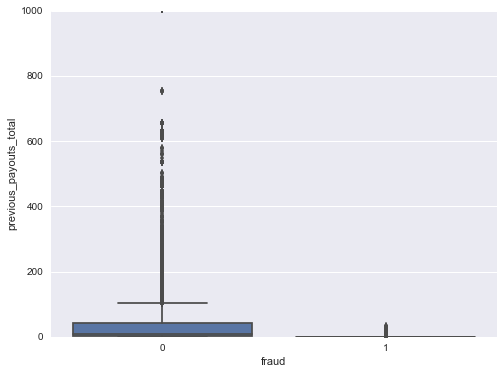

In [14]:
# EDA to show the difference of previous_payouts_total between two classes.
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot(x='fraud', y='previous_payouts_total', data=df_new)
plt.ylim([0,1000])
plt.show()

In [15]:
df_new.groupby('fraud').previous_payouts_total.value_counts(normalize=True).unstack()

previous_payouts_total,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,329,330,337,345,355,366,369,377,384,389,394,395,406,410,412,413,426,434,437,439,446,461,470,479,487,488,491,502,535,537,549,561,570,579,608,618,628,630,654,656,754,1006,1113,1264,1282,1407,1502,1666,1972,2048
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.004203,0.186050,0.086155,0.058191,0.044775,0.037824,0.025297,0.023438,0.02069,0.020852,0.015437,0.014790,0.015356,0.01277,0.013012,0.011153,0.012851,0.008001,0.009456,0.008567,0.007759,0.007920,0.008567,0.007355,0.007840,0.0059,0.006304,0.005738,0.0059,0.003799,0.005657,0.004768,0.004526,0.00493,0.004526,0.003799,0.003394,0.003718,0.004041,0.00299,0.003071,0.003394,0.002505,0.004203,0.003475,0.001859,0.001697,0.002586,0.003152,0.002667,...,0.000323,0.000323,0.001212,0.000162,0.001051,0.000566,0.000081,0.000081,0.000081,0.001536,0.00097,0.000808,0.001374,0.000242,0.002263,0.001212,0.000808,0.001616,0.000081,0.001131,0.000727,0.001536,0.001536,0.001293,0.00097,0.000404,0.000242,0.000242,0.001697,0.000647,0.000081,0.000323,0.000081,0.000242,0.000889,0.001293,0.000081,0.001131,0.001697,0.001293,0.000485,0.001616,0.003152,0.002829,0.005415,0.001616,0.003718,0.002505,0.003799,0.001616
1,0.771848,0.080433,0.030936,0.027842,NaN,0.005414,0.006961,0.001547,0.00232,0.004640,0.003094,0.000773,0.001547,NaN,0.007734,NaN,NaN,NaN,0.001547,NaN,NaN,0.003094,0.010054,NaN,0.018561,NaN,NaN,NaN,NaN,0.019335,NaN,NaN,0.002320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Assumption: Fraudsters tend to creat user_accounts and soon creat the events . Since they are not long term users,
# the time between event_created and user_created should be much shorter.
# We created a new feature - duration_days.
df_new['duration'] = df_new.event_created - df_new.user_created
df_new['duration_days'] = df_new.duration.apply(lambda x: x.days)
df_new.groupby('fraud').duration_days.value_counts(normalize=True).unstack()

duration_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1855,1861,1871,1875,1893,1897,1903,1904,1911,1945,1946,1953,1958,1974,1976,1986,1994,1997,2021,2029,2030,2043,2049,2079,2113,2155,2170,2172,2190,2203,2206,2213,2219,2230,2244,2273,2331,2371,2392,2446,2448,2500,2532,2911,2996,3561,3604,3611,3688,3793
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.167381,0.008244,0.005900,0.003556,0.003637,0.003960,0.003879,0.002748,0.002667,0.002748,0.002101,0.002101,0.002586,0.002990,0.002263,0.001616,0.002101,0.001212,0.002505,0.002263,0.002021,0.002101,0.001616,0.001778,0.001051,0.001778,0.002505,0.002021,0.001536,0.001212,0.001293,0.001697,0.001536,0.00291,0.001374,0.001616,0.002021,0.001616,0.001374,0.001293,0.000970,0.002182,0.001374,0.001051,0.001293,0.001051,0.001455,0.001536,0.001455,0.002101,...,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,NaN,NaN,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081
1,0.576179,0.025522,0.012374,0.010828,0.013921,0.013921,0.013148,0.008507,0.005414,0.011601,0.006187,0.006961,0.004640,0.006187,0.002320,0.003867,0.005414,0.017788,0.005414,0.002320,0.007734,0.004640,0.003094,0.005414,0.002320,0.002320,0.000773,0.004640,0.003094,0.003094,0.000773,0.006187,0.003094,0.00464,0.003094,0.002320,0.002320,0.003094,0.000773,0.000773,0.000773,0.003094,0.001547,0.001547,0.000773,0.002320,0.002320,0.002320,NaN,0.000773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001547,0.008507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


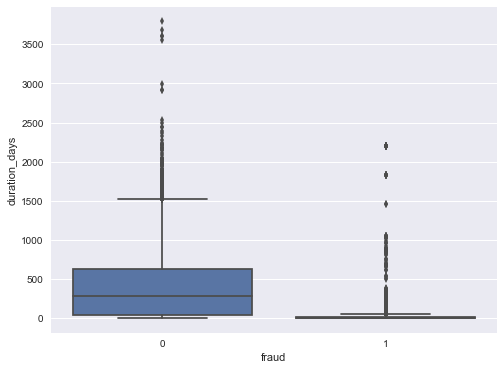

In [17]:
# EDA showed us there was a big difference in duration_days  between two classes.
sns.boxplot(x='fraud', y='duration_days', data=df_new)
plt.show()

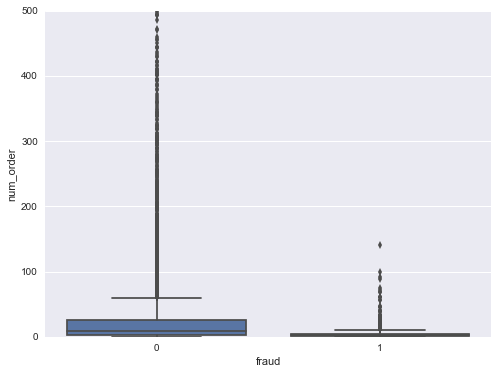

In [18]:
# EDA to show the difference of num_order between two classes.
sns.boxplot(x='fraud', y='num_order', data=df_new)
plt.ylim([0,500])
plt.show()

In [19]:
df_new.groupby('fraud').num_order.value_counts(normalize=True).unstack()

num_order,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,555,558,563,564,567,571,575,578,595,606,614,617,622,651,652,653,654,655,683,739,742,745,786,789,833,843,853,875,876,881,901,932,934,975,1015,1040,1054,1081,1083,1141,1200,1216,1286,1349,1374,1520,1552,1659,1696,2000
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000566,0.155015,0.082680,0.061262,0.051726,0.042189,0.034268,0.033541,0.032005,0.028449,0.022468,0.021660,0.019640,0.018589,0.017861,0.01673,0.014467,0.012446,0.011881,0.012608,0.010103,0.010426,0.010588,0.008890,0.009133,0.008405,0.007112,0.00792,0.007436,0.006547,0.005981,0.006142,0.007436,0.005496,0.004768,0.005334,0.005657,0.004203,0.004041,0.004284,0.003475,0.003556,0.004284,0.004445,0.003556,0.004041,0.003718,0.003071,0.003233,0.003475,...,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.00097
1,0.247486,0.221964,0.126063,0.084300,0.068059,0.041763,0.035576,0.020108,0.023202,0.015468,0.014695,0.010828,0.009281,0.006187,0.009281,0.00464,0.003867,0.003867,0.006187,0.006187,0.004640,0.003094,0.003867,0.001547,0.001547,0.003867,0.000773,NaN,NaN,0.000773,0.000773,0.002320,NaN,0.000773,0.001547,NaN,NaN,NaN,0.000773,0.000773,0.000773,0.000773,NaN,NaN,NaN,0.000773,0.000773,0.000773,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


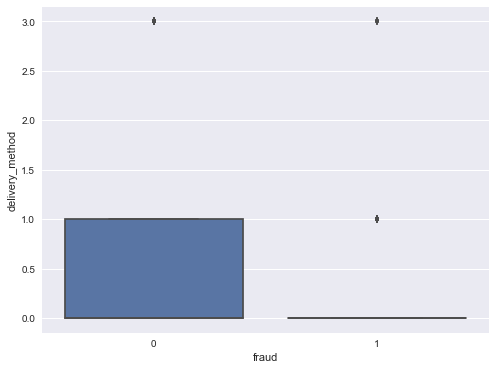

In [20]:
# EDA to show the difference of delivery_method between two classes.
sns.boxplot(x='fraud', y='delivery_method', data=df_new)
plt.show()

In [21]:
df_new.groupby('fraud').delivery_method.value_counts(normalize=True).unstack()

delivery_method,0.0,1.0,3.0
fraud,,,
0,0.558897,0.422346,0.018757
1,0.937549,0.056987,0.005464


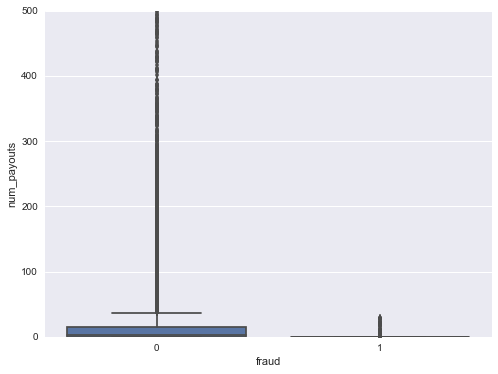

In [22]:
# EDA to show the difference of num_payouts between two classes.
sns.boxplot(x='fraud', y='num_payouts', data=df_new)
plt.ylim([0,500])
plt.show()

In [23]:
df_new.groupby('fraud').num_payouts.value_counts(normalize=True).unstack()

num_payouts,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1051,1068,1069,1072,1075,1094,1095,1104,1115,1122,1126,1133,1137,1140,1145,1149,1153,1156,1158,1170,1185,1191,1206,1211,1218,1229,1230,1233,1244,1245,1292,1293,1297,1298,1300,1326,1345,1350,1394,1418,1419,1464,1488,1559,1564,1584,1606,1621,1633,1858
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.327083,0.110078,0.067486,0.044775,0.034915,0.027479,0.023519,0.019801,0.016407,0.016083,0.014467,0.011557,0.010345,0.009779,0.008567,0.007759,0.006385,0.007193,0.005819,0.006547,0.006223,0.005334,0.005819,0.005577,0.003475,0.004284,0.004849,0.004041,0.003071,0.003556,0.004526,0.002344,0.00299,0.00291,0.002586,0.002425,0.001616,0.002101,0.002505,0.002748,0.002182,0.002667,0.001859,0.001778,0.001374,0.002182,0.001536,0.001778,0.001859,0.001859,...,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000323,0.000081,0.000242,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162
1,0.892498,0.042537,0.013921,0.013921,0.002320,0.003867,0.003094,0.008507,0.000773,0.002320,NaN,0.002320,0.000773,NaN,0.000773,NaN,0.000773,0.000773,0.000773,0.000773,0.000773,0.000773,0.000773,0.001547,NaN,NaN,0.000773,0.000773,0.000773,0.003094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


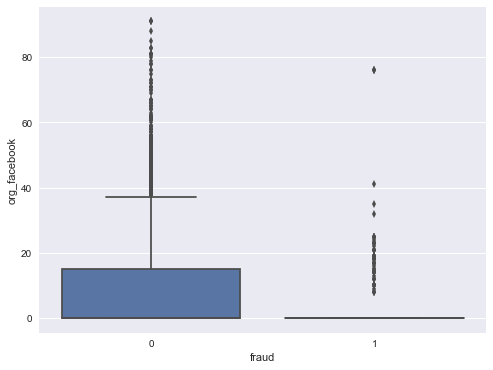

In [24]:
# EDA to show the difference of org_facebook between two classes.
sns.boxplot(x='fraud', y='org_facebook', data=df_new)
plt.show()

In [25]:
df_new.groupby('fraud').org_facebook.value_counts(normalize=True).unstack()

org_facebook,0.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,69.0,70.0,71.0,72.0,73.0,75.0,76.0,78.0,79.0,80.0,81.0,83.0,85.0,88.0,91.0
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.534562,0.000162,0.000243,0.004447,0.007276,0.011723,0.016008,0.021020,0.026114,0.027084,0.038079,0.030156,0.030479,0.030237,0.028862,0.018757,0.020778,0.015846,0.014229,0.012612,0.010348,0.013663,0.006549,0.004042,0.0038,0.004042,0.004285,0.004366,0.002911,0.00194,0.003962,0.003072,0.002183,0.002183,0.002345,0.00283,0.001779,0.00671,0.002183,0.002021,0.001455,0.002183,0.00097,0.002345,0.001859,0.001536,0.002345,0.001374,0.000404,0.000889,0.001051,0.001294,0.000566,0.000728,0.001374,0.000243,0.000323,0.000323,0.000081,0.000728,0.000566,0.000081,0.000243,0.000243,0.000243,0.000323,0.000081,0.000162,0.000243,0.000162,0.000162,0.000081,0.000162,0.000162,0.000081,0.000081,0.000404,0.000162,0.000081,0.000081,0.000243
1,0.949111,NaN,NaN,NaN,NaN,NaN,0.002423,0.000808,0.006462,NaN,0.002423,0.000808,0.005654,0.001616,0.000808,0.004039,0.004039,0.004039,NaN,0.003231,0.000808,0.004039,0.000808,0.004039,NaN,NaN,NaN,NaN,NaN,NaN,0.000808,NaN,NaN,0.000808,NaN,NaN,NaN,NaN,NaN,0.000808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


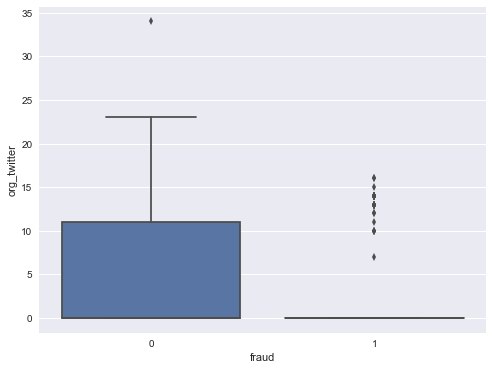

In [26]:
# EDA to show the difference of org_twitter between two classes.
sns.boxplot(x='fraud', y='org_twitter', data=df_new)
plt.show()

In [27]:
df_new.groupby('fraud').org_twitter.value_counts(normalize=True).unstack()

org_twitter,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,34.0
fraud,,,,,,,,,,,,,,,,,,,,,,,
0,0.609103,0.003072,0.000162,0.002264,0.005013,0.010429,0.013582,0.024416,0.025305,0.034037,0.038968,0.045921,0.045355,0.050934,0.062495,0.026680,0.00097,0.000323,0.000081,0.000243,0.000162,0.000404,0.000081
1,0.977383,NaN,NaN,NaN,NaN,NaN,0.000808,NaN,NaN,0.002423,0.000808,0.001616,0.005654,0.008885,0.000808,0.001616,NaN,NaN,NaN,NaN,NaN,NaN,NaN


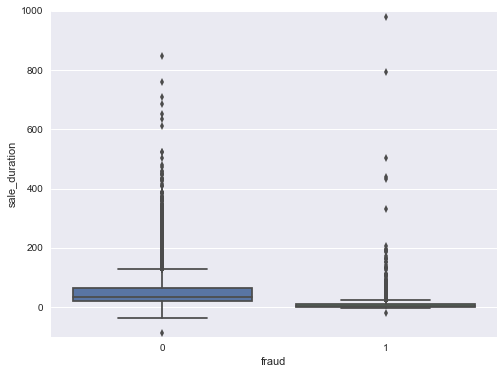

In [28]:
# EDA to show the difference of sale_duration between two classes.
sns.boxplot(x='fraud', y='sale_duration', data=df_new)
plt.ylim([-100,1000])
plt.show()

In [29]:
df_new.groupby('fraud').sale_duration.value_counts(normalize=True).unstack()

sale_duration,-1094.0,-143.0,-86.0,-37.0,-36.0,-28.0,-24.0,-19.0,-13.0,-10.0,-8.0,-6.0,-5.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,...,337.0,340.0,342.0,344.0,345.0,346.0,349.0,351.0,358.0,361.0,362.0,363.0,364.0,368.0,370.0,371.0,375.0,384.0,385.0,386.0,388.0,407.0,408.0,416.0,427.0,429.0,431.0,432.0,436.0,440.0,446.0,449.0,450.0,455.0,458.0,471.0,478.0,502.0,504.0,522.0,523.0,611.0,636.0,651.0,686.0,709.0,761.0,792.0,848.0,980.0
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,NaN,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000162,0.000324,0.015725,0.010213,0.007781,0.007295,0.008592,0.008106,0.007700,0.010943,0.012240,0.012483,0.012888,0.013050,0.012159,0.014266,0.013942,0.016941,0.017265,0.016292,0.014104,0.016130,0.013942,0.016860,0.018886,0.017589,0.017103,0.015644,0.016292,0.016617,0.015239,0.017103,0.018319,0.016049,0.015320,0.012888,...,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000081,0.000081,0.000081,0.000324,0.000081,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000162,0.000162,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,NaN,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,NaN,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,NaN,0.000081,NaN
1,0.000851,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,NaN,NaN,NaN,NaN,NaN,0.001702,NaN,0.004255,0.131915,0.188936,0.105532,0.067234,0.083404,0.056170,0.041702,0.021277,0.018723,0.017872,0.015319,0.012766,0.005106,0.008511,0.006809,0.005106,0.005957,0.009362,0.008511,0.005957,0.004255,0.001702,0.009362,0.006809,0.004255,0.006809,0.004255,0.001702,0.002553,0.002553,0.002553,0.003404,0.000851,0.001702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,NaN,0.000851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000851,NaN,0.000851


In [30]:
df_new_final = df_new[['duration_days', 'delivery_method', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', 'sale_duration', \
                       'previous_payouts_total', 'fraud']].dropna()

# Build the Model

In [31]:
feature_cols = ['duration_days', 'delivery_method', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', 'sale_duration', \
                'previous_payouts_total']

In [32]:
X_new_final = df_new_final[feature_cols]
y_new_final = df_new_final.fraud

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_new_final, y_new_final, test_size=0.1)

In [34]:
rf = RandomForestClassifier(n_estimators=200)

In [35]:
# cross_validation_score for training dataset.
cv = cross_val_score(rf, X_train, y_train, cv=5).mean()

In [36]:
cv

0.98258353763949702

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [38]:
# Confusion_matrix of the testing dataset.
confusion_matrix(y_test, rf.predict(X_test))

array([[1245,    8],
       [   9,   85]])

In [39]:
y_pred_proba = rf.predict_proba(X_test)[:,1]

In [40]:
print 'Accuracy_Score = {:.2f}\nRecall_Score = {:.2f}\nPrecision_Score = {:.2f}\nAuc_Score = {:.4f}'.format(\
        rf.score(X_test, y_test),\
        recall_score(y_test, rf.predict(X_test)),\
        precision_score(y_test, rf.predict(X_test)),\
        roc_auc_score(y_test, y_pred_proba))

Accuracy_Score = 0.99
Recall_Score = 0.90
Precision_Score = 0.91
Auc_Score = 0.9783


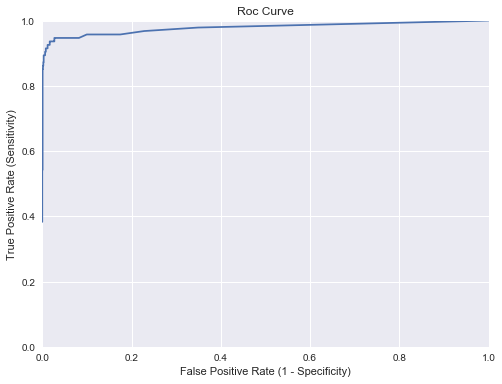

In [41]:
# Plot ROC Curve.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()